# Soccer Player Archetype Detection and Clustering

### Importing Packages and Reading Data

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import *
from sklearn import metrics 
from scipy.spatial.distance import cdist 

In [66]:
def data_reader(original_path):
    data_original = pd.read_csv(original_path)
    return data_original

In [67]:
data_path = './data/data.csv' 
data_pd = data_reader(data_path)

### Defining Some Functions to Complete the Pre-processing Process

- data_separator() takes the original pandas dataframe, drops unnecessary attributes and any instances with null value. Then, it returns players and goalkeepers seperately. I seperated goalkeepers from other players since goalkeepers have different characteristics in terms of attributes. Goalkeeper archetype clustering might be a potential future work.

- organize_attributes() functions take the pandas dataframe of players, and then it creates a list of special features: pace, shooting, passing, dribbling, defending and pythsical. (goalkeeping skills are not used in this study.) These features are adapted from the stats of original FIFA player cards (https://www.futbin.com/stats-calculator).

- organize_attributes_takeAll() directly returns the quantitative statistics given in the dataset (without calculating any extra feature). 

- weight_formatter() and height_formatter() takes the dataframe of players and returns their numeric weight and height data in terms of lbs and centimeters.

In [68]:

def data_separator(data_original):
    """
    - seperates goalkeepers from the players, returns as a new pandas df, 'goalkeepers'.
    - cleans the unnecessary attributes of the data instances and returns the players as a pandas df, 'players'.
    """
    
    goalkeepers = data_original[data_original['Position'] == 'GK']
    goalkeepers = goalkeepers.drop(['Unnamed: 0','ID','Photo','Flag','Potential','Club',\
    'Club Logo','Value','Wage','Special','Preferred Foot','International Reputation','Weak Foot','Skill Moves',\
    'Work Rate','Body Type','Real Face','Position','Jersey Number','Joined','Loaned From','Contract Valid Until',\
    'Release Clause', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',\
    'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'], axis=1)
    
    players = data_original[data_original.Position != 'GK']

    players = data_original.drop(['Unnamed: 0','ID','Photo','Flag','Potential','Club',\
    'Club Logo','Value','Wage','Special','Preferred Foot','International Reputation','Weak Foot','Skill Moves',\
    'Work Rate','Body Type','Real Face','Position','Jersey Number','Joined','Loaned From','Contract Valid Until',\
    'Release Clause'], axis=1)
    
    # if still, there are instances with NaN values, delete them all.
    players = players.dropna(how='any',axis=0) 

    """
    print(players.columns)
    ==> 
    Index(['Name', 'Age', 'Overall', 'Potential', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')
    """
    players = players.reset_index(drop=True)
    goalkeepers = goalkeepers.reset_index(drop=True)


    return players, goalkeepers

In [69]:
def organize_attributes_takeAll(players):
    
    return players[['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']]


def organize_attributes(players):    
    attribute_groups = dict()
    attribute_groups['pace'] = ['Acceleration','SprintSpeed']
    attribute_groups['shooting'] = ['Finishing','LongShots','Penalties','Positioning','ShotPower','Volleys']
    attribute_groups['passing'] = ['Crossing','Curve','FKAccuracy','LongPassing','ShortPassing','Vision']
    attribute_groups['dribbling'] = ['Agility','Balance','BallControl','Composure','Dribbling','Reactions']
    attribute_groups['defending'] = ['HeadingAccuracy','Interceptions','Marking','StandingTackle','SlidingTackle']
    attribute_groups['physical'] = ['Aggression','Jumping','Stamina','Strength']
    # attribute_groups['gk'] = ['GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes']
    
    
    attr_list = []

    for value in attribute_groups.values():
        attr_list += value



    pace_index = (players[attribute_groups['pace']].mean(axis=1)) 
    shooting_index = (players[attribute_groups['shooting']].mean(axis=1)) 
    passing_index = (players[attribute_groups['passing']].mean(axis=1)) 
    dribbling_index = (players[attribute_groups['dribbling']].mean(axis=1))
    defending_index = (players[attribute_groups['defending']].mean(axis=1))
    physical_index = (players[attribute_groups['physical']].mean(axis=1)) 
    # gk_index = (players[attribute_groups['gk']].mean(axis=1)) 

    # pos_list = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM',\
    # 'LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']
    # position_data = players[pos_list]
    #position_data = position_data.div(players['Overall'].values, axis = 0)


    all_index= pd.concat([pace_index,shooting_index,passing_index, dribbling_index,
                          defending_index,physical_index], axis=1 , ignore_index=True)


    all_index.columns = ['pace_index','shooting_index','passing_index',
                         'dribbling_index','defending_index','physical_index']
    
    """
    Critical Step: All newly generated attributes are in the scale of [0,100]. 
    Generated attributes are divided by the mean of all these attributes.  
    """
    all_index = all_index.div(all_index.mean(axis=1).to_frame()[0], axis=0)
    
    return all_index.round(2)

In [70]:
def weight_formatter(players):
    """
    all weights are used in lbs.
    """
    
    for index, row in players.iterrows():
        players.at[index, 'Weight'] = float(row['Weight'].split('lbs')[0])
    
    return players['Weight']


def height_formatter(players):
    """
    converted all heights to centimeters.
    """
    for index, row in players.iterrows():
        players.at[index, 'Height'] = round(float(row['Height'].split("'")[0]) * 30.48 + float(row['Height'].split("'")[1]) * 2.54)
    
    return players['Height']

In [71]:
# Dropping the goalkeeper instances and removing unnecessary attributes.
data_pd_cleaned, goalkeepers = data_separator(data_pd)

# Creating some new features by using the columns in the input dataframe.
data_fielded = organize_attributes(data_pd_cleaned)

# Creating height and weight attributes for each player and adding to the current dataframe data_fielded.
data_fielded['height'] = height_formatter(data_pd_cleaned)
data_fielded['weight'] = weight_formatter(data_pd_cleaned)

### Rescaling the Input Data
Two options are presented to scale the data attributes:
- option == 0: min-max normalization
- option == 1: standardization


In [72]:
def rescale_df(df, option = 0):
    """
    set option to 0 for normalization
    set option to 1 for standardization
    """
    if option == 0:
        temp_df = (df - df.min())/(df.max() - df.min()) 
    elif option == 1:
        temp_df = (df - df.mean()) / df.std()
    return temp_df
    



In [73]:
# applying min-max normalization
rescaled_data = rescale_df(data_fielded, 0)
rescaled_data[:2]

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight
0,0.511628,0.743590,0.773196,0.716418,0.123077,0.160377,0.3125,0.368421
1,0.503876,0.752137,0.608247,0.537313,0.153846,0.367925,0.6875,0.548872


## Clustering 

After completing the data extraction process, we are are ready to start clustering. Clustering will be done based on the following features:
- pace_index : ['Acceleration','SprintSpeed']
- shooting_index : ['Finishing','LongShots','Penalties','Positioning','ShotPower','Volleys']
- passing_index : ['Crossing','Curve','FKAccuracy','LongPassing','ShortPassing','Vision']
- dribbling_index : ['Agility','Balance','BallControl','Composure','Dribbling','Reactions']
- defending_index : ['HeadingAccuracy','Interceptions','Marking','StandingTackle','SlidingTackle']
- physical_index : ['Aggression','Jumping','Stamina','Strength']
- height
- weight

### Finding the Ideal Number of Clusters
The main purpose of clustering operation is to generate clusters with a minimized intra-cluster variation.

In order to define the optimal number of clusters, the elbow method is applied in a range of [0, 15].



Text(0, 0.5, 'loss values')

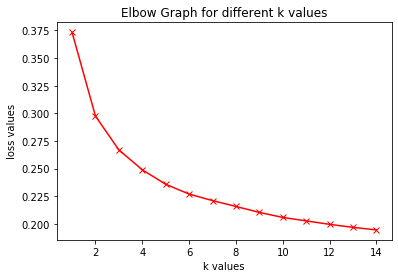

In [83]:
loss_k = list()


k_range = range(1,15)

for k in k_range:  
    temp_model = KMeans(n_clusters=k).fit(rescaled_data)     
      
    loss_k.append(sum(np.min(cdist(rescaled_data, temp_model.cluster_centers_, 
                      'euclidean'),axis=1)) / rescaled_data.shape[0]) 

plt.plot(k_range, loss_k, 'rx-')
plt.title('Elbow Graph for different k values')
plt.xlabel('k values')
plt.ylabel('loss values')

__Here comes a discussion.__

Although the optimal k value resulted from the previous figure is 4 (might also be 3 or 5), the results when I picked k=4 were not satisfactory for me (Some players that I would consider in seperate clusters were in the same cluster). After this obsevation, I decided to set k value as 10, as the number of clusters is a user specified parameter at all.

In [15]:
number_of_clusters = 10

kmeanModel = KMeans(n_clusters = number_of_clusters ) 
kmeanModel.fit(rescaled_data) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

After completing the clustering operation, some identifier attributes (Name and Age) and the cluster labels of players are added so that similar players in each cluster will be observed. 

In [86]:
rescaled_data['Name'] = data_pd_cleaned['Name']
rescaled_data['Age'] = data_pd_cleaned['Age']
rescaled_data['Cluster'] = kmeanModel.labels_

In [55]:
top3_results = pd.DataFrame()




In [58]:
for each in range(number_of_clusters):
    top3_results=pd.concat([top3_results,rescaled_data[rescaled_data['Cluster']==each][:3]],axis=0)
    #print(rescaled_data[rescaled_data['Cluster']==each][:3])

# rescaled_data[rescaled_data['Cluster']==8]

In [57]:
top3_results

,pace_index,shooting_index,passing_index,dribbling_index,defending_index,physical_index,height,weight,Name,Age,Cluster
36,0.503876,0.128205,0.247423,0.358209,0.838462,0.660377,0.6875,0.646617,K. Koulibaly,27,0
52,0.550388,0.324786,0.402062,0.298507,0.707692,0.452830,0.729167,0.518797,R. Varane,25,0
63,0.434109,0.324786,0.288660,0.388060,0.761538,0.575472,0.6875,0.729323,M. Benatia,31,0
12,0.410853,0.470085,0.474227,0.507463,0.576923,0.424528,0.270833,0.368421,N. Kanté,27,1
40,0.519380,0.478632,0.546392,0.432836,0.530769,0.311321,0.3125,0.300752,Jordi Alba,29,1
53,0.302326,0.478632,0.659794,0.671642,0.553846,0.301887,0.208333,0.165414,M. Verratti,25,1
3,0.372093,0.683761,0.731959,0.477612,0.338462,0.311321,0.520833,0.330827,K. De Bruyne,27,2
5,0.364341,0.615385,0.701031,0.597015,0.438462,0.226415,0.375,0.270677,L. Modrić,32,2
11,0.333333,0.683761,0.783505,0.746269,0.284615,0.216981,0.375,0.285714,David Silva,32,2
9,0.271318,0.700855,0.783505,0.492537,0.500000,0.150943,0.583333,0.43609,T. Kroos,28,3
